In [1]:
from glob import glob
from tqdm import tqdm

import aesara.tensor as at
import arviz as az
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
%matplotlib inline
plt.style.use("bayes.mplstyle")

mpl.rcParams["figure.dpi"] = 120
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["axes.spines.left"] = False
FIGSIZE = (12, 7)

# Read raw data and clean it

Raw data was taken from ESPN Result tab for each team

In [3]:
raw_files = glob("data/raw/*.csv")

In [4]:
def clean_one_df(df):
    cols = [c for c in df.columns if ('ref' not in c) and ('Image' not in c)]
    idxs = [i for i, col_name in enumerate(cols) if col_name.startswith('matchTeams')]
    table_td_idxs = [i for i, col_name in enumerate(cols) if col_name.startswith('Table__TD')]
    out = []
    for idx, table_td_idx in zip(idxs, table_td_idxs):
        _df = df.copy()
        df_batch = pd.DataFrame()
        df_batch['date'] = pd.to_datetime(_df['Table__Title'])
        df_batch['day'] = _df[cols[idx]].str.extract(r'(\d+)')
        df_batch['home_team'] = _df[cols[idx + 1]]
        df_batch['away_team'] = _df[cols[idx + 3]]
        df_batch['score'] = _df[cols[idx + 2]]
        df_batch['type'] = _df[cols[table_td_idx]]
        df_batch['home_score'] = df_batch['score'].str.split("-").str[0]
        df_batch['away_score'] = df_batch['score'].str.split("-").str[1]
        df_batch.dropna(inplace=True)
        out.append(df_batch)
    return pd.concat(out, ignore_index=True)

def clean_all_df(raw_files):
    out = []
    for file in (t:=tqdm(raw_files)):
        t.set_description_str(f'Reading file {file}')
        df = pd.read_csv(file)
        t.set_description_str(f'Cleaning file {file.split("/")[2]}')
        out.append(clean_one_df(df))
    out = pd.concat(out).sort_values(by = 'date')
    out['home_score'] = out['home_score'].astype(int)
    out['away_score'] = out['away_score'].astype(int)
    return out.drop_duplicates().reset_index(drop=True)

In [5]:
data = clean_all_df(raw_files)

Cleaning file tunisia.csv: 100%|██████████| 32/32 [00:00<00:00, 99.39it/s]             


In [6]:
teams = set(data['home_team'])
data[~data['away_team'].apply(lambda x: x in teams)]

date day                 home_team  \
31  2021-03-01  31              Saudi Arabia   
61  2021-05-01  28                     Japan   
69  2021-06-01   6              Saudi Arabia   
112 2021-06-01  15                     Japan   
118 2021-06-01   5               South Korea   
224 2021-09-01   6                     Spain   
225 2021-09-01   8                   Denmark   
335 2021-11-01  15                   Senegal   
339 2021-11-01  16               Switzerland   
355 2022-01-01  26                   Senegal   
398 2022-03-01  27                   Germany   
419 2022-03-01  29                   Croatia   
432 2022-03-01  27                     Qatar   
452 2022-04-01  28                    Mexico   
499 2022-06-01  10                    Canada   
510 2022-06-01  10                   Senegal   
515 2022-06-01   5  Central African Republic   
516 2022-06-01  11             United States   
518 2022-06-01  12                   Ecuador   
525 2022-06-01   6                Costa Rica   
530 2022-07-01  17                Mozambique   
550 2022-09-01   4                   Nigeria   
576 2022-09-01   3                    Guinea   
584 2022-10-01  24                     Qatar   
609 2022-11-01  18                   Morocco   

                                             away_team   score  \
31                                           Palestine   5 - 0   
61                                             Myanmar  10 - 0   
69                                               Yemen   3 - 0   
112                                    Kyrgyz Republic   5 - 1   
118                                       Turkmenistan   5 - 0   
224                                            Georgia   4 - 0   
225                                             Israel   5 - 0   
335                                              Congo   2 - 0   
339                                           Bulgaria   4 - 0   
355                                 Cape Verde Islands   2 - 0   
398                                             Israel   2 - 0   
419                                           Bulgaria   2 - 1   
432                                           Bulgaria   2 - 1   
452                                          Guatemala   0 - 0   
499                                            Curacao   4 - 0   
510                                              Niger   3 - 1   
515                    Ghana wins 3-1 on Penalty Kicks   0 - 0   
516                                            Grenada   5 - 0   
518                                 Cape Verde Islands   1 - 0   
525                                         Martinique   2 - 0   
530            2nd Leg · Senegal wins 4-2 on aggregate   1 - 2   
550  2nd Leg · Tied 2-2 on aggregate · Nigeria wins...   2 - 0   
576            2nd Leg · Senegal wins 2-1 on aggregate   1 - 1   
584                                          Guatemala   2 - 0   
609                                            Georgia   3 - 0   

                                        type  home_score  away_score  
31           FIFA World Cup Qualifying - AFC           5           0  
61           FIFA World Cup Qualifying - AFC          10           0  
69           FIFA World Cup Qualifying - AFC           3           0  
112          FIFA World Cup Qualifying - AFC           5           1  
118          FIFA World Cup Qualifying - AFC           5           0  
224         FIFA World Cup Qualifying - UEFA           4           0  
225         FIFA World Cup Qualifying - UEFA           5           0  
335          FIFA World Cup Qualifying - CAF           2           0  
339         FIFA World Cup Qualifying - UEFA           4           0  
355                    Africa Cup of Nations           2           0  
398                   International Friendly           2           0  
419                   International Friendly           2           1  
432                   International Friendly           2           1  
452                   International Friendly      

In [7]:
# Not worth to think how to automate this
data.loc[515, 'away_team'] = 'Ghana'
data.loc[530, 'away_team'] = 'Senegal'
data.loc[550, 'away_team'] = 'Senegal'
data.loc[576, 'away_team'] = 'Senegal'

In [8]:
test_data = data.query("type == 'FIFA World Cup'").copy()
data = data[data['type'] != 'FIFA World Cup']

## Create team dictionary

In [9]:
teams = teams.union(set(data[~data['away_team'].apply(lambda x: x in teams)].away_team))

In [10]:
# Mappings useful for the model
id2team = dict(enumerate(teams))
team2id = {v: k for k, v in id2team.items()}

# Modeling

The vector of observed scores is $y = (y_{g}^{home}, y_{g}^{away})$ is modelled as independent Poisson:
    $$ y_{g}^{j} | \theta_{g}^{j} ~ Poisson(\theta_{g}^{j})$$

Where the parameters $\theta_{g}^{j}$  represent the scoring intensity in the $g-th$ game for the team playing at $j = home$ and $j = away$, respectively.

We model these parameters according to a formulation that has been used widely in the statistical literature (see Karlis & Ntzoufras 2003), assumming a log-linear random effect model:

$$log(\theta_{g}^{home}) = \eta + \alpha_{h(g)} + \delta_{a(g)}$$
$$log(\theta_{g}^{home}) = \alpha_{h(g)} + \delta_{a(g)}$$

The parameter $\eta$ represents the advantage for the team hosting the game and we assume that this effect is constant for all the teams and throughout the timewindow in our data. In addition, the scoring intensity is determined jointly by the attact and defense ability of the two teams involved, represented by the parameters $\alpha$ and $\delta$. The nested indexes $h(g)$, $a(g)$ identify the team that is playing at home (away) in the $g-th$ game.

As suggested by various works we need to impose some identifiability constraints on the team-specific parameters. We use a sum-to-zero constraint, that is:

$$ \sum_{t=1}^{T} \alpha_{t} = 0 \quad \sum_{t=1}^{T} \delta_{t} = 0 $$

In [11]:
home_idx = data['home_team'].map(team2id).values
away_idx = data['away_team'].map(team2id).values

coords = {"team": teams}

In [12]:
with pm.Model(coords=coords) as model:

    # Data inputs
    home_team = pm.MutableData("home_team", home_idx)
    away_team = pm.MutableData("away_team", away_idx)
    
    # Home field effect
    eta = pm.Normal("eta", mu=0, sigma=1)

    # Average score (log scale)
    mu = pm.Normal('mu', 0.4, sigma=1)

    # Team attack and defense skills
    alpha = pm.Normal("alpha", mu=0, sigma=1, dims="team")
    delta = pm.Normal("delta", mu=0, sigma=1, dims="team")
    
    # constrain the offense and defense skills to sum to zero
    alpha_star = pm.Deterministic("alpha_star", alpha - at.mean(alpha), dims="team")  
    delta_star = pm.Deterministic("delta_star", delta - at.mean(delta), dims="team") 
    
    # expected values for the home and away teams in each game can be calculated as
    home_theta = at.exp(mu + eta + alpha_star[home_team] + delta_star[away_team])
    away_theta = at.exp(mu + alpha_star[away_team] + delta_star[home_team])
    
    # the likehoods of the observed scores
    home_score = pm.Poisson(
        "home_score",
        mu=home_theta,
        observed=data["home_score"].to_numpy()
    )
    away_score = pm.Poisson(
        "away_score",
        mu=away_theta,
        observed=data["away_score"].to_numpy()
    )

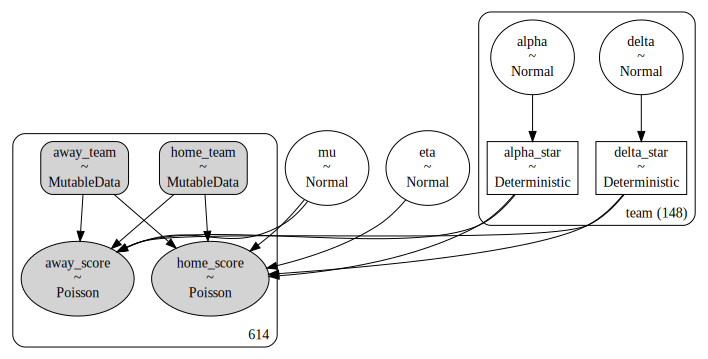

In [13]:
pm.model_to_graphviz(model)

In [14]:
with model:
    trace = pm.sample(random_seed=42, cores = 8)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [eta, mu, alpha, delta]


Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 37 seconds.


## Analyze the posterior: MCMC checks

/Users/c3po/miniconda3/envs/ib_advanced_regression/lib/python3.10/site-packages/arviz/plots/traceplot.py:217: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (594), generating only 20 plots
  warnings.warn(


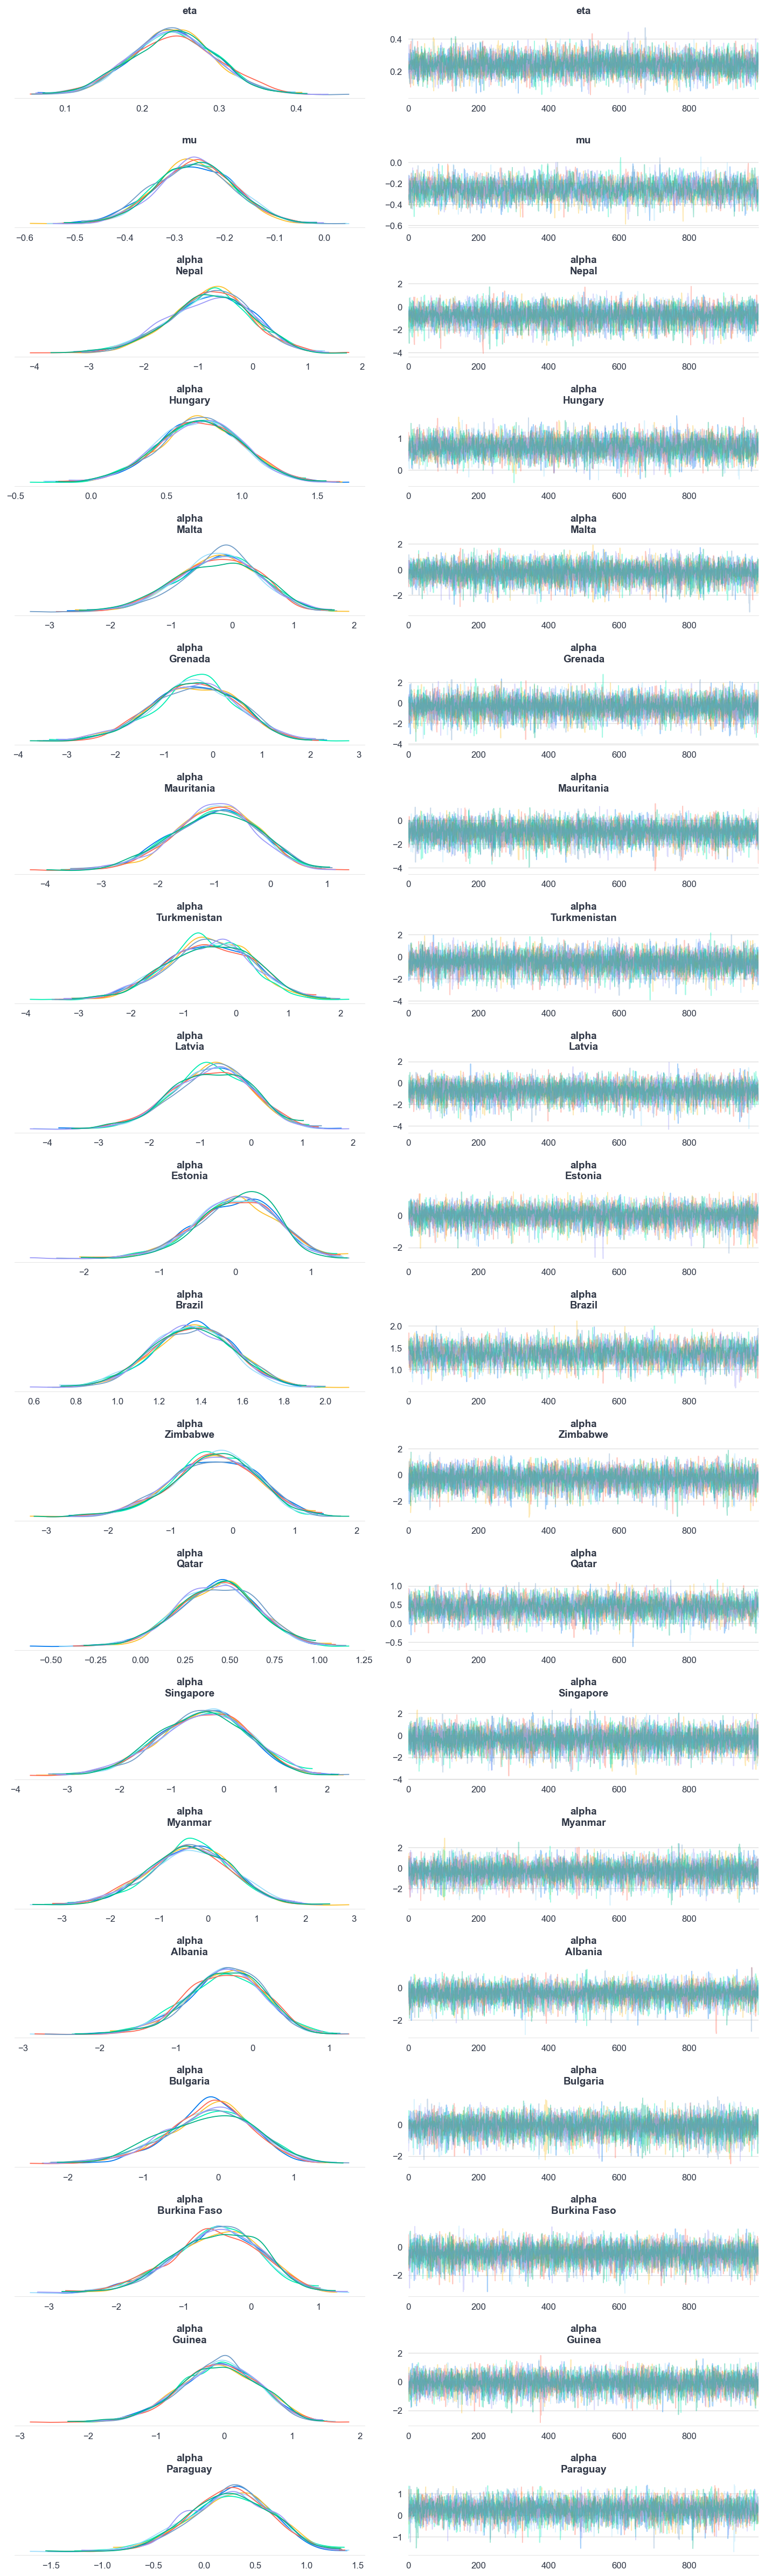

In [15]:
az.plot_trace(trace, compact=False, backend_kwargs={"tight_layout": True});

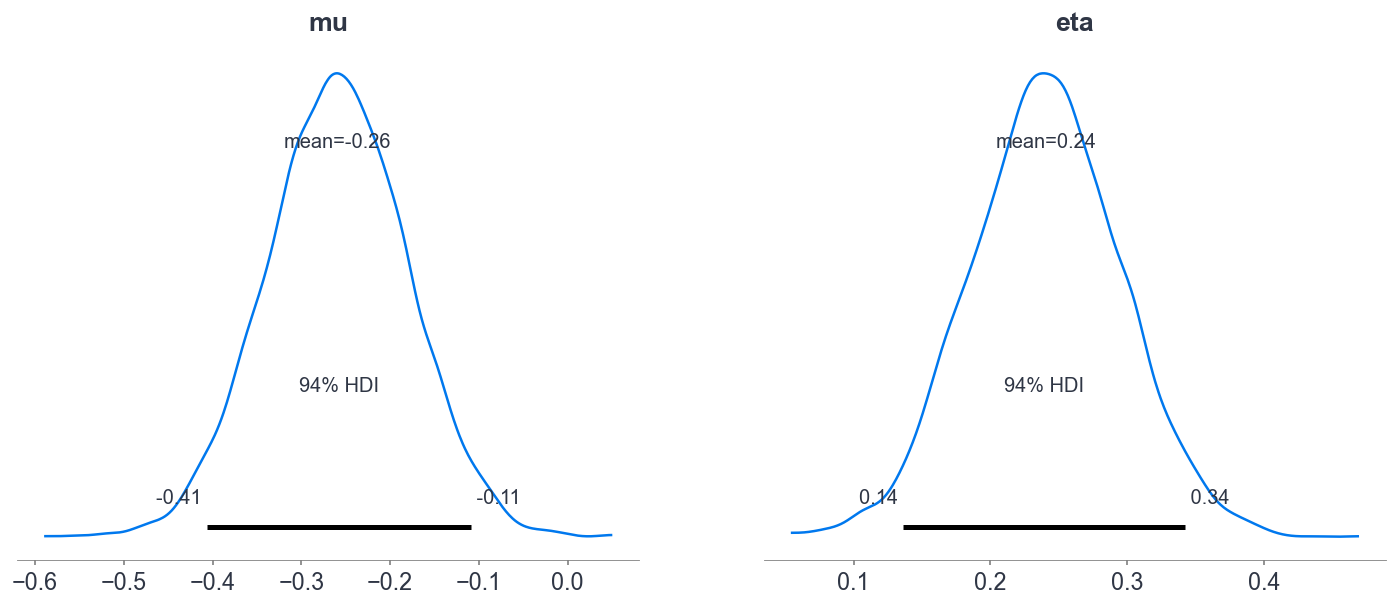

In [16]:
az.plot_posterior(trace, var_names=["mu", "eta"]);

In [17]:
# score of average home team
np.exp(trace.posterior.mu.mean() + trace.posterior.eta.mean()).item()

0.9809641293361362

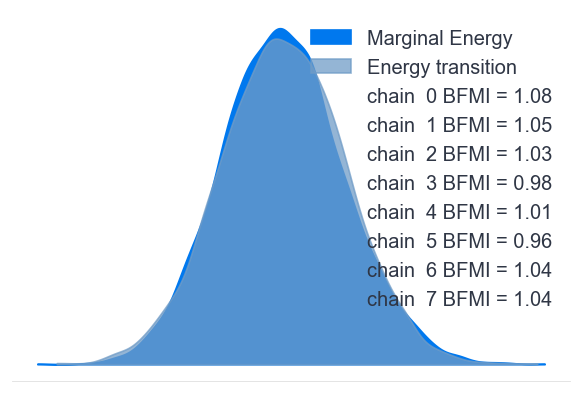

In [18]:
az.plot_energy(trace, figsize=(6, 4));

## Analyze the posterior: High Level Summary

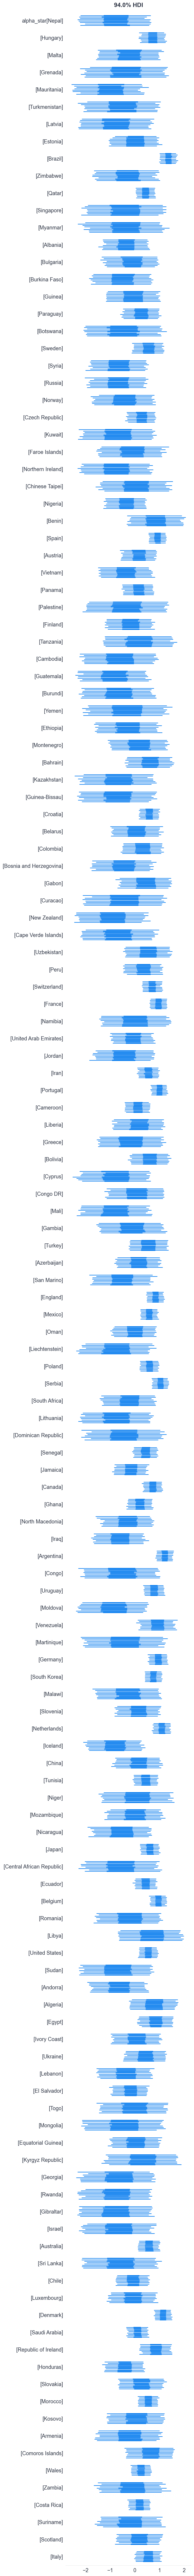

In [19]:
az.plot_forest(trace, var_names=["alpha_star"]);

# Making Predictions

In [20]:
home_teams_idx = test_data['home_team'].map(team2id).values
away_teams_idx = test_data['away_team'].map(team2id).values

with model:
    pm.set_data({
            "home_team": home_teams_idx,
            "away_team": away_teams_idx,
        
    })
    pm.sample_posterior_predictive(
        trace,
        predictions=True,
        extend_inferencedata=True,
        random_seed=42,
    )

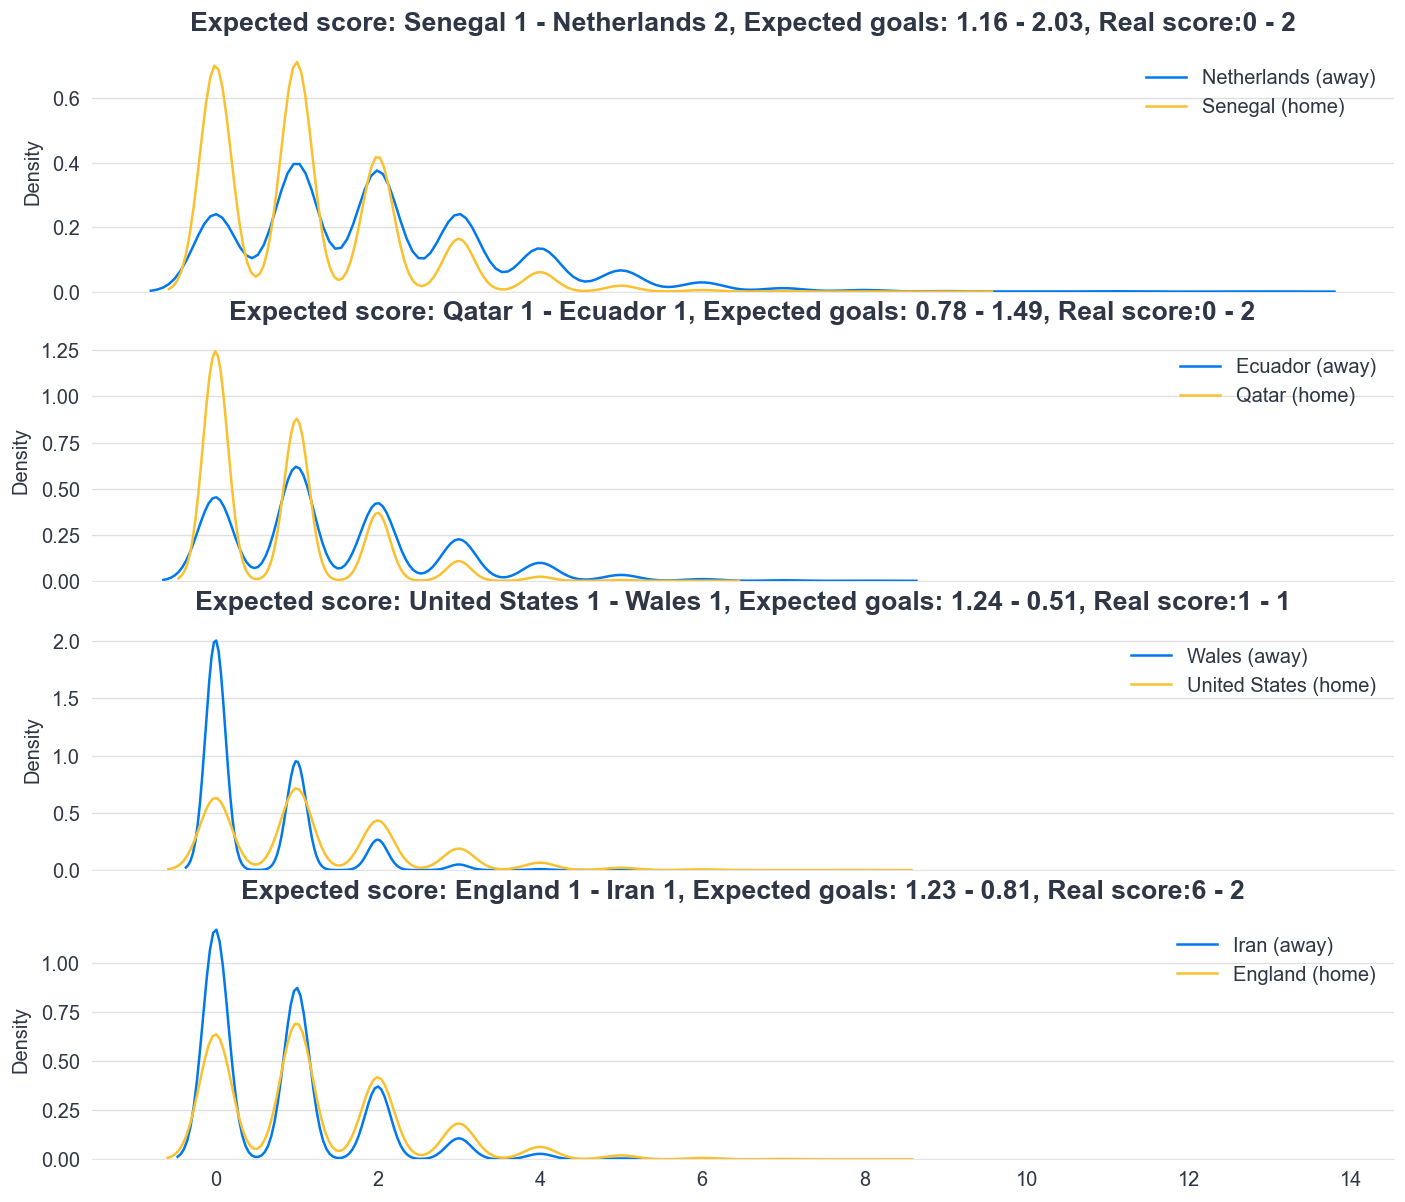

In [21]:
home_teams = test_data['home_team'].to_list()
away_teams = test_data['away_team'].to_list()
real_score = test_data['score'].to_list()
fig, axes = plt.subplots(len(home_teams), 1, figsize=(14, 12), sharex=True)

for i, (home_team, away_team) in enumerate(zip(home_teams, away_teams)):
    
    expected_goals = f"Expected goals: {trace.predictions.home_score[:, :, i].mean().item():.2f} - {trace.predictions.away_score[:, :, i].mean().item():.2f}"
    expected_scores = f"Expected score: {home_team} {trace.predictions.home_score[:, :, i].mean().item():.0f} - {away_team} {trace.predictions.away_score[:, :, i].mean().item():.0f}"
    home_pred = trace.predictions['home_score'][:, :, i].values.flatten()
    away_pred = trace.predictions['away_score'][:, :, i].values.flatten()

    sns.kdeplot(away_pred, label=f"{away_team} (away)", ax=axes[i]);
    sns.kdeplot(home_pred, label=f"{home_team} (home)", ax=axes[i]);
    axes[i].legend([f"{away_team} (away)", f"{home_team} (home)"]);
    axes[i].title.set_text(expected_scores + ", " + expected_goals + ", Real score:" + real_score[i])

In [27]:
# Predict future matches
home_teams = ['Argentina', 'Denmark', 'Mexico', 'France', 'Morocco', 'Germany']
away_teams = ['Saudi Arabia', 'Tunisia', 'Poland', 'Australia', 'Croatia', 'Japan']

home_teams_idx = [team2id[team] for team in home_teams]
away_teams_idx = [team2id[team] for team in away_teams]

In [28]:
with model:
    pm.set_data({
            "home_team": home_teams_idx,
            "away_team": away_teams_idx,
        
    })
    predictions = pm.sample_posterior_predictive(
        trace,
        predictions=True,
        random_seed=42,
    )

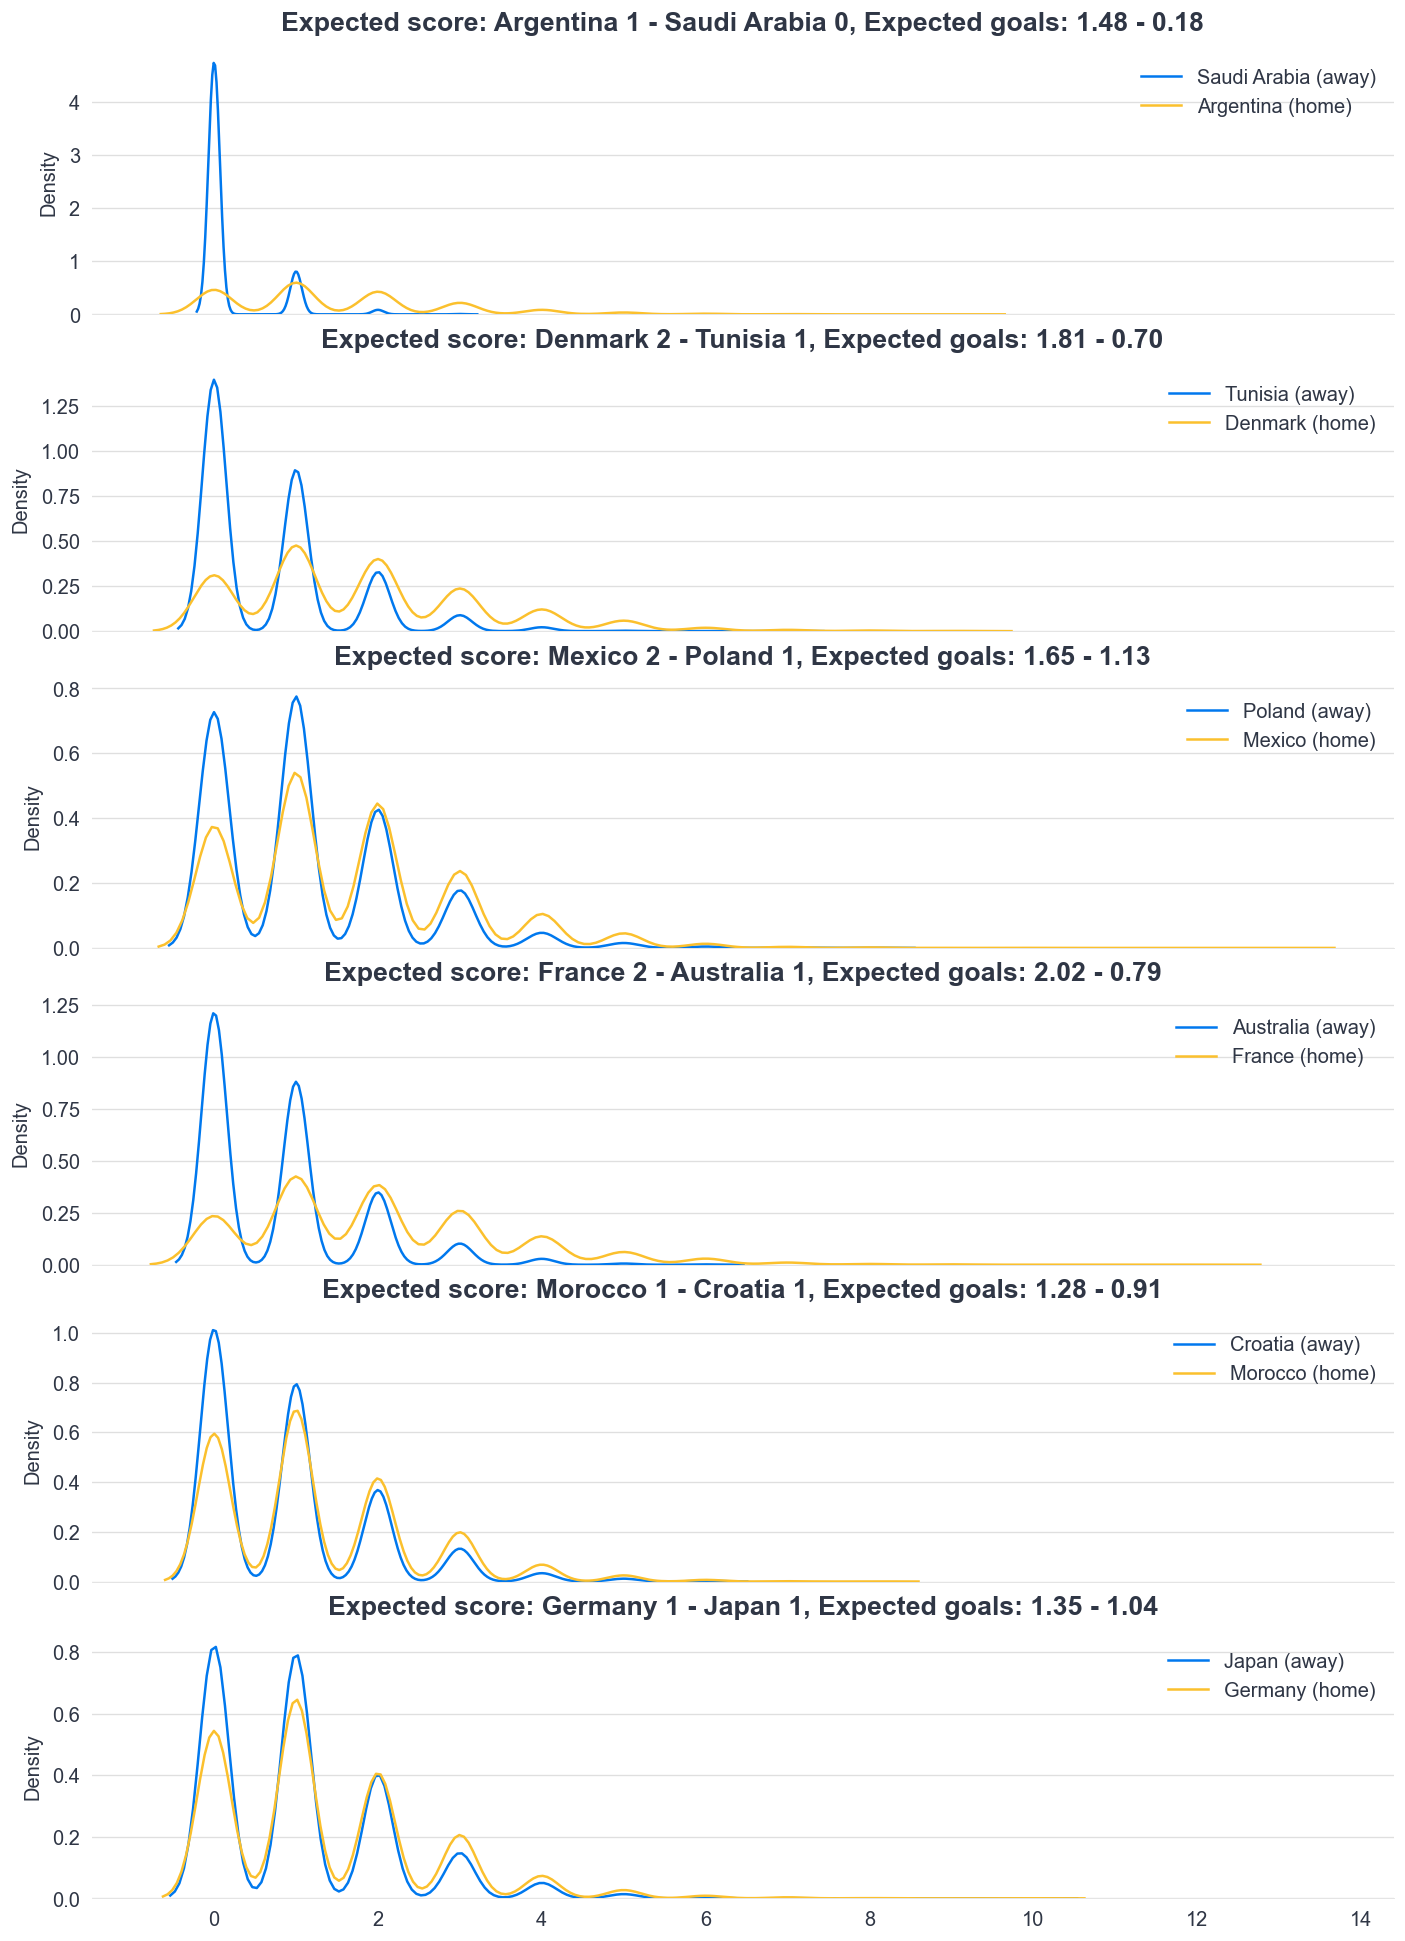

In [32]:
fig, axes = plt.subplots(len(home_teams), 1, figsize=(14, 20), sharex=True)

for i, (home_team, away_team) in enumerate(zip(home_teams, away_teams)):
    
    expected_goals = f"Expected goals: {predictions.predictions.home_score[:, :, i].mean().item():.2f} - {predictions.predictions.away_score[:, :, i].mean().item():.2f}"
    expected_scores = f"Expected score: {home_team} {predictions.predictions.home_score[:, :, i].mean().item():.0f} - {away_team} {predictions.predictions.away_score[:, :, i].mean().item():.0f}"
    home_pred = predictions.predictions['home_score'][:, :, i].values.flatten()
    away_pred = predictions.predictions['away_score'][:, :, i].values.flatten()

    sns.kdeplot(away_pred, label=f"{away_team} (away)", ax=axes[i]);
    sns.kdeplot(home_pred, label=f"{home_team} (home)", ax=axes[i]);
    axes[i].legend([f"{away_team} (away)", f"{home_team} (home)"]);
    axes[i].title.set_text(expected_scores + ", " + expected_goals)

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Tue Nov 22 2022

Python implementation: CPython
Python version       : 3.10.4
IPython version      : 8.6.0

arviz     : 0.14.0
matplotlib: 3.5.2
sys       : 3.10.4 | packaged by conda-forge | (main, Mar 24 2022, 17:39:37) [Clang 12.0.1 ]
aesara    : 2.7.9
pymc      : 4.1.5
seaborn   : 0.11.2
pandas    : 1.4.2
numpy     : 1.22.4

Watermark: 2.3.1

